# Финальный проект

Импортируем необходимые для работы библиотеки:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandahouse as ph

## Задание 1. A/B–тестирование
#### 1.1 Условие 

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

#### 1.2 Входные данные

Имеем 4 csv-файла:

In [31]:
groups       = pd.read_csv('groups.csv', sep=';') # - таблица о принадлежности пользователя к контрольной или экспериментальной
                                                  #   группе (А – контроль, B – целевая группа); 
group_add    = pd.read_csv('group_add.csv')       # - таблица с пользователями, которую вам прислали спустя 2 дня после передачи
                                                  #   данных;
active_studs = pd.read_csv('active_studs.csv')    # - таблица с информацией о пользователях, которые зашли на платформу в 
                                                  #   дни проведения эксперимента;
checks       = pd.read_csv('checks.csv', sep=';') # - таблица с информацией об оплатах пользователей в дни проведения                                              
                                                  #   эксперимента. 

#### 1.3 Вопросы

__Проведем развездывательный анализ:__

Посмотрим на типы данных, пропуски и наполнение таблиц:

In [85]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [86]:
groups.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [87]:
group_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [142]:
group_add.head(3)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


In [143]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [144]:
active_studs.head(3)

,student_id
0,581585
1,5723133
2,3276743


In [91]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [92]:
checks.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


Доболним таблицу с пользователями наших групп с новыми пользователями, добавленными спустя 2 дня после передачи данных: 

In [32]:
all_students = pd.concat([groups, group_add]).reset_index(drop=True)

In [33]:
all_students

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


Проверим полученный датасет на дубликаты:

In [34]:
print(f'Дубликатов в полученном датасете: {all_students.duplicated().sum()}')

Дубликатов в полученном датасете: 0


Посмотрим на активных пользователей и их наличие в датасете, где происходило деление по группам:

In [35]:
all_students = all_students.rename(columns={'id': 'student_id'})

In [36]:
search1 = all_students.merge(active_studs, on='student_id', how='inner')

In [37]:
search1.shape[0] == active_studs.shape[0]

True

Посмотрим на активных пользователей и тех, кто совершил попупку:

In [38]:
search2 = active_studs.merge(checks, on='student_id', how='left')

In [39]:
search2

,student_id,rev
0,581585,NaN
1,5723133,NaN
2,3276743,NaN
3,4238589,NaN
4,4475369,NaN
...,...,...
8336,1794344,NaN
8337,296883,NaN
8338,3598448,NaN
8339,3610547,290.0


In [40]:
not_in_groups = checks.shape[0] - search2.query('rev != "NaN"').shape[0]

In [41]:
not_in_groups

149

In [42]:
print(f'{not_in_groups} пользователей купили услугу, но по неизвестной причине не оказались среди активных пользователей \
и среди наших выборочных групп. Данная ситуация при работе требовала бы разбирательства.')

149 пользователей купили услугу, но по неизвестной причине не оказались среди активных пользователей и среди наших выборочных групп. Данная ситуация при работе требовала бы разбирательства.


Пользователи, которые купили услугу и есть в таблице активных:

In [43]:
checks_filtered = checks.merge(active_studs, on='student_id', how='inner')

In [44]:
checks_filtered

,student_id,rev
0,1627,990.0000
1,100300,990.0000
2,108270,290.0000
3,264473,1900.0001
4,274352,690.0000
...,...,...
387,5645737,1900.0000
388,5651566,1900.0000
389,5662322,1900.0000
390,5681918,1900.0000


Дальнейшую работу будем проводить по имеющейся таблице с активностью пользователей - __active_studs__ и теми пользователями, которые совершили покупку и попали в эту таблицу активных - __checks_filtered__:

В качестве метрик, по которым будем давать оценку новой механике оплаты услуг на сайте, примем: ARPU, CR и дополнительно посчитаем AVG check. Данные метрики являются базовыми и служат хорошим индикатором положения дел в бизнесе.



Объединим имеющиеся таблицы в одну для расчета метрик:

In [45]:
df = active_studs.merge(all_students, on='student_id', how='left') \
                 .merge(checks_filtered, on='student_id', how='left')

In [46]:
df

,student_id,grp,rev
0,581585,A,NaN
1,5723133,A,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN
...,...,...,...
8336,1794344,B,NaN
8337,296883,B,NaN
8338,3598448,B,NaN
8339,3610547,B,290.0


Проверим на наличие дубликатов нашу таблицу и пропуски:

In [47]:
df.duplicated().sum()

0

In [48]:
df.isna().sum()

student_id       0
grp              0
rev           7949
dtype: int64

Рассчитаем метрики:

In [49]:
df

,student_id,grp,rev
0,581585,A,NaN
1,5723133,A,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN
...,...,...,...
8336,1794344,B,NaN
8337,296883,B,NaN
8338,3598448,B,NaN
8339,3610547,B,290.0


In [50]:
income = df.groupby('grp', as_index=False) \
           .agg({'rev': 'sum'}).round(2) \
           .rename(columns={'rev': 'income'})

results = df.groupby('grp', as_index=False) \
            .agg({'student_id': 'count',
                  'rev': 'count'}) \
            .rename(columns={'student_id': 'users',
                             'rev': 'pay_users'})
results = results.merge(income, on='grp')
results['ARPU'] = round(results.income / results.users, 2)
results['CR'] = round(results.pay_users / results.users, 3)
results['AVG_check'] = round(results.income / results.pay_users, 2)

In [51]:
results

,grp,users,pay_users,income,ARPU,CR,AVG_check
0,A,1538,78,72820.0,47.35,0.051,933.59
1,B,6803,314,394974.0,58.06,0.046,1257.88


Проверим, является разница в средних чеках(__AVG_check__) между группами статистически значимой. Сформулируем гипотезы для проверки вклада новой механики:  
·Нулевая гипотеза (H0): Разницы между средними чеками в группах нет;  
·Альтернативная гипотеза (H1): Разница между средними чеками в группах есть.

Посмотрим на размеры наших групп:

In [52]:
size_groups = df.query('rev > 0') \
                .groupby('grp', as_index=False) \
                .agg({'student_id': 'count'})
size_groups

,grp,student_id
0,A,78
1,B,314


Посмотрим боксплоты для наших групп:

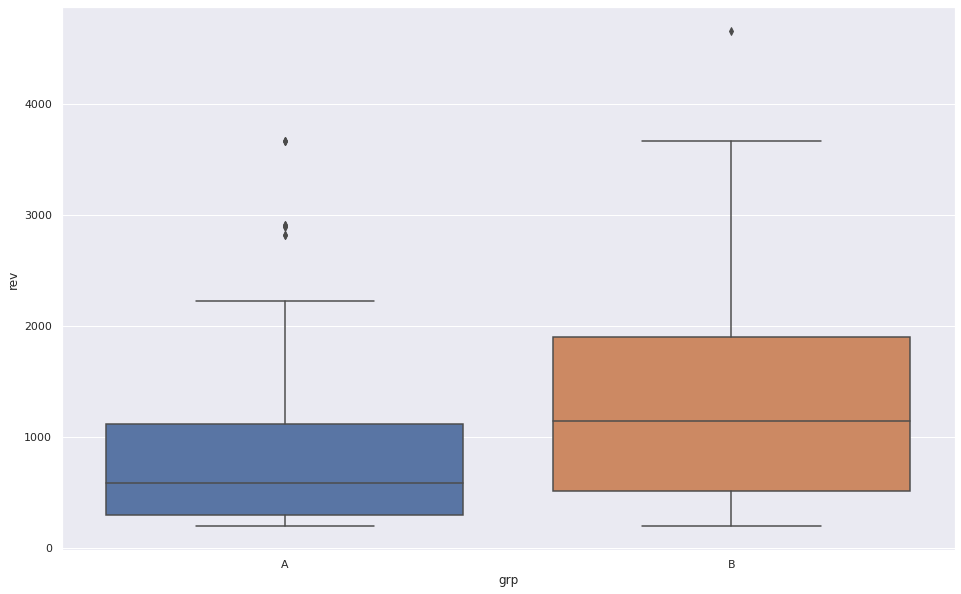

In [53]:
AB_df = df.query('rev > 0')
sns.boxplot(x='grp', y='rev', data=AB_df)
sns.set(rc={'figure.figsize':(10,6)})

Посмотрим на распредление чеков:

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


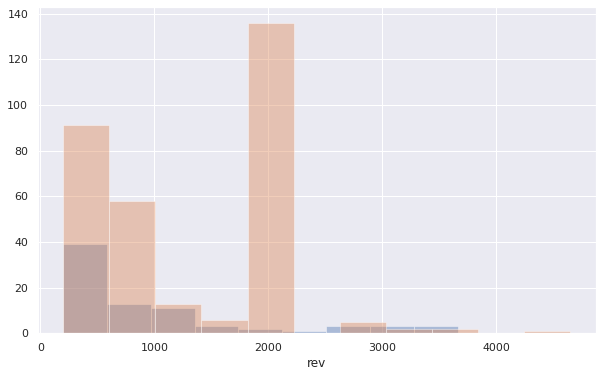

In [55]:
sns.distplot(AB_df[AB_df.grp == 'A'].rev, kde=False)
sns.distplot(AB_df[AB_df.grp == 'B'].rev, kde=False)

Распределения в группах имеют выбросы и с виду являются ненормальными, убедимся в этом с помощью теста Шапиро-Уилка. В качестве критического уровня примем α=0.05:

In [56]:
pv_A = stats.shapiro(AB_df[AB_df.grp == 'A'].rev)
print(f'Уровень значимости p-value группы А = {round(pv_A[1],3)}')
pv_B = stats.shapiro(AB_df[AB_df.grp == 'B'].rev)
print(f'Уровень значимости p-value группы В = {round(pv_B[1],3)}')

Уровень значимости p-value группы А = 0.0
Уровень значимости p-value группы В = 0.0


Как результат: распределения изучаемого признака ненормальны. 

Статистическую значимость исследуемого признака определим с помощью бутстрапа, поскольку бутстрап проверяет статистические гипотезы без опоры на определенное теоретическое распределение данных в отличие от классических стат. критериев, которые не приветливы к дисбалансу. Это сказывается в первую очередь на мощности критерия - чем сильнее дисбаланс, тем реже критерий будет обнаруживать реальную разницу (эффект):

In [84]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

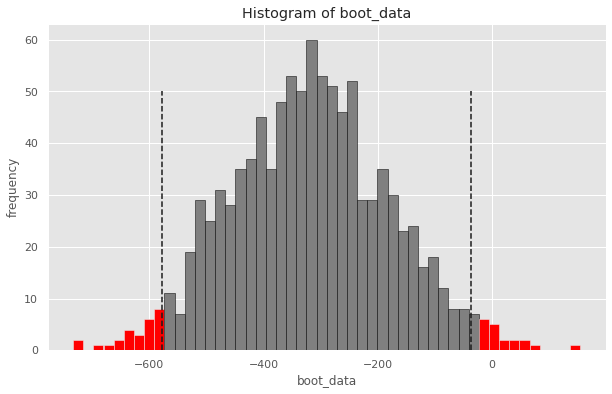

{'boot_data': [-252.64103717948717,
  -514.8974461538463,
  -279.9359089743592,
  -308.2051397435897,
  -149.76924102564112,
  -339.4230871794872,
  -286.6794974358976,
  -220.7564269230768,
  -286.5256487179489,
  -331.47437564102574,
  -376.19231666666667,
  -486.6923205128204,
  45.08973846153822,
  -106.65385897435908,
  -145.9230923076925,
  -99.8974461538462,
  -354.025655128205,
  -310.3718089743588,
  -438.3718,
  -296.8461666666668,
  -421.41026923076936,
  -448.0897525641027,
  -498.48718974358985,
  -478.33334615384626,
  -308.4615500000001,
  -109.91026666666676,
  -451.23077692307686,
  -276.02565384615366,
  -28.11539358974369,
  -534.923094871795,
  -234.24359230769232,
  -265.7564243589742,
  -34.00001153846142,
  -22.166682051282123,
  -419.53847564102557,
  -498.34616282051286,
  -464.5256538461539,
  -331.7436,
  -418.17949999999996,
  -398.21796153846174,
  -298.2692358974359,
  -564.1282141025642,
  -336.8333410256413,
  -250.21795641025642,
  -521.8846307692307,
 

In [77]:
get_bootstrap(
    AB_df[AB_df.grp == 'A'].rev, # числовые значения первой выборки
    AB_df[AB_df.grp == 'B'].rev, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
             )

P value получили равным 0.0206. На полученной гистограмме мы можем наблюдать распределение разностей между средними бутстрапированных выборок. Если бы разница между средними отсутстовавала, то средняя разность между средними равнялась бы нулю. Здесь же мы наблюдаем, что усредненная разность между средними равняется примерно -300.  
Применяя бутстрап с оценкой среднего, в данном конкретном эксмперименте мы отклоняем нулевую гипотезу о равенстве средних при критическом уровне α=0.05 и делаем вывод, что тестовая и контрольная выборки различаются.  
Что касается метрик, то вместе с 10% снижением показателся CR, средний чек увеличился на 34%, а ARPU вырос на 23%. При этом на данном этапе не стоит запускать новую механику на всех пользователей, поскольку остался открытым вопрос о 149 пользователях, которые не попали в таблицу активных пользователей и составляют 27,5% от числа наших платящих пользователей.

## __Задание 2. SQL__
#### 2.1 Очень усердные ученики
#### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц __правильно__ решил 20 горошин.

#### 2.1.2 Задача

Дана таблица default.peas:

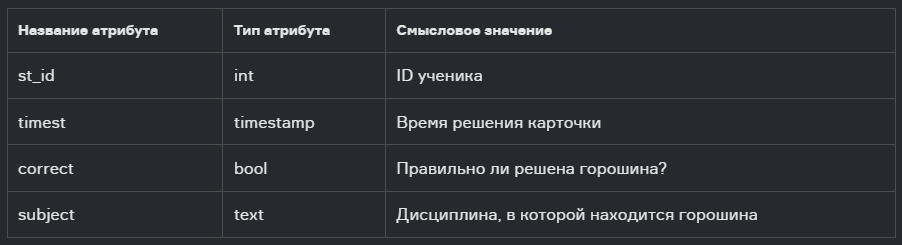

Необходимо написать __оптимальный запрос__, который даст информацию о количестве очень усердных студентов за март 2020 года. 

*NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.*

__Решение__

Подключимся сперва к ClickHouse:

In [5]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database': 'default',
                      'user': 'student',
                      'password': 'dpo_python_2020'
                     }

Проведем разведывательный анализ:

Выясним диапазон дат в нашем датасете:

In [62]:
q1 = '''
     SELECT MIN(toDate(timest)),
            MAX(toDate(timest))
       FROM peas;
     '''

In [63]:
df1 = ph.read_clickhouse(query=q1, connection=connection_default)
df1

,min(toDate(timest)),max(toDate(timest))
0,2021-10-30,2021-10-31


In [ ]:
Несмотря на отсутствие необходимой даты - март 2020 года, отразим необходимый запрос:

In [75]:
q2 = '''
     SELECT COUNT(st_id) AS active_users_march
       FROM (SELECT st_id, toStartOfMonth(timest) AS time,
                    SUM(correct) AS score
               FROM peas
              WHERE correct = 1
              GROUP BY st_id, time
             HAVING score >= 20 
                AND time = '2020-03-01')
     '''

In [76]:
df2 = ph.read_clickhouse(query=q2, connection=connection_default)
df2

,active_users_march
0,0


#### 2.2  Оптимизация воронки

#### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

#### 2.2.2 Задачи

Даны таблицы: __default.peas (см. выше)__, __default.studs__:

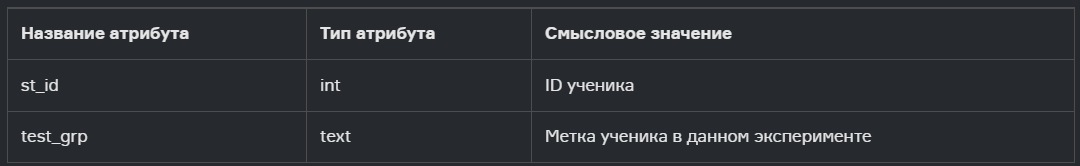

и __default.final_project_check__:

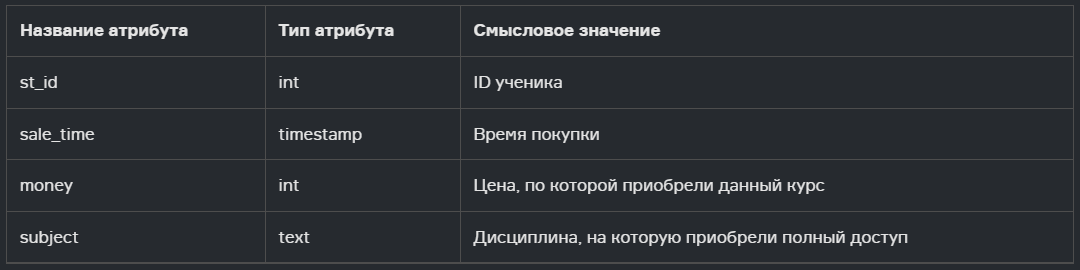

Необходимо __в одном запросе__ выгрузить следующую информацию о группах пользователей:

·ARPU     
·ARPAU   
·CR в покупку   
·СR активного пользователя в покупку   
·CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике  

__ARPU считается относительно всех пользователей, попавших в группы.__

__Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.__  

__Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.__  

__Решение__

Пояснения к подзапросам:  
    ·sq1 - деление юзеров по группам;  
    ·sq2 - заработанные деньги по группам;  
    ·sq3 - юзеры, набравшие больше 10 очков;  
    ·sq4 - деление юзеров, набравших больше 10 очков, по группам;  
    ·sq5 - деление юзеров, которые купили курс(ы), по группам;  
    ·sq6, sq8 - юзеры, набравшие 2 и более очков по математике;  
    ·sq7 - деление юзеров, набравших 2 и более очков по математике, по группам;  
    ·sq9 - юзеры, купившие курс по математике;  
    ·sq10 - деление активных юезров, купивших курс по математике, по группам.  

In [22]:
q3 = '''
     SELECT sq1.test_grp as test_grp, 
            ROUND(sq2.money / sq1.count_test_grp, 2) AS ARPU,
            ROUND(sq2.money / sq4.active_users, 2) AS ARPAU,
            ROUND(sq5.premium_users / sq1.count_test_grp, 2) AS CR,
            ROUND(sq5.premium_users / sq4.active_users, 2) AS CR_active,
            ROUND(sq10.premium_active_math_users / sq7.active_math_users, 2) AS CR_active_math 
       FROM (SELECT test_grp, COUNT(test_grp) AS count_test_grp 
               FROM studs
              GROUP BY test_grp
            ) AS sq1
            JOIN 
            (SELECT test_grp, SUM(money) AS money
               FROM studs 
                    LEFT JOIN final_project_check
                    ON studs.st_id = final_project_check.st_id
              GROUP BY test_grp
            ) AS sq2
            ON sq1.test_grp = sq2.test_grp
       
            JOIN 
            (SELECT test_grp, COUNT(sq3.st_id) AS active_users
               FROM studs 
                    LEFT JOIN
                    (SELECT st_id, SUM(correct) AS score
                       FROM peas 
                      GROUP BY st_id
                     HAVING score > 10
                    ) AS sq3
                    ON studs.st_id = sq3.st_id
              WHERE score != 0 
              GROUP BY test_grp
            ) AS sq4
            ON sq2.test_grp = sq4.test_grp

            JOIN
            (SELECT test_grp,
                    COUNT(DISTINCT final_project_check.st_id) AS premium_users
               FROM studs LEFT JOIN final_project_check
                          ON studs.st_id = final_project_check.st_id
              WHERE final_project_check.money != 0
              GROUP BY test_grp
            ) AS sq5
            ON sq4.test_grp = sq5.test_grp
            
            JOIN 
            (SELECT test_grp, COUNT(test_grp) AS active_math_users
               FROM studs LEFT JOIN
                          (SELECT st_id, SUM(correct) AS score_math
                             FROM peas
                            WHERE subject = 'Math'
                            GROUP BY st_id, subject
                           HAVING score_math >= 2
                          ) AS sq6
                          ON studs.st_id = sq6.st_id
              WHERE score_math != 0
              GROUP BY test_grp) AS sq7
            ON sq5.test_grp = sq7.test_grp
              
            JOIN
            (SELECT test_grp,
                    COUNT(*) AS premium_active_math_users
               FROM (SELECT st_id, 
                            SUM(correct) AS score_math
                       FROM peas
                      WHERE subject = 'Math'
                      GROUP BY st_id, subject
                     HAVING score_math >= 2
                      ORDER BY score_math
                    ) AS sq8
            
            JOIN 
            (SELECT *
               FROM final_project_check
              WHERE subject = 'Math'
            ) AS sq9
            ON sq8.st_id = sq9.st_id
            
            JOIN studs
            ON sq9.st_id = studs.st_id
              GROUP BY test_grp) AS sq10
            ON sq7.test_grp = sq10.test_grp
     '''

In [23]:
df3 = ph.read_clickhouse(query=q3, connection=connection_default)
df3

,test_grp,ARPU,ARPAU,CR,CR_active,CR_active_math
0,control,4540.98,10905.51,0.05,0.12,0.06
1,pilot,11508.47,35364.58,0.11,0.33,0.10


## __Задание 3. Python__
#### 3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.  
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [2]:
def actual_metrics(new_users):
    '''Функция автоматически подгружает из дополнительного 
       файла информацию о пользователях, меняет заголовки,
       т.к. они могут отличаться и пересчитвает метрики.
    '''
    new_users = pd.read_csv(new_users)
    new_users.rename(columns={new_users.columns[0]: 'student_id', new_users.columns[1]: 'grp'}, inplace=True)
    groups = pd.read_csv('groups.csv', sep=';')
    groups.rename(columns={'id': 'student_id'}, inplace=True)
    active_studs = pd.read_csv('active_studs.csv')
    checks = pd.read_csv('checks.csv', sep=';')
    all_students = pd.concat([groups, new_users]).reset_index(drop=True)
    checks_filtered = checks.merge(active_studs, on='student_id', how='inner')
    df = active_studs.merge(all_students, on='student_id', how='left') \
                 .merge(checks_filtered, on='student_id', how='left')
    income = df.groupby('grp', as_index=False) \
           .agg({'rev': 'sum'}).round(2) \
           .rename(columns={'rev': 'income'})
    results = df.groupby('grp', as_index=False) \
                .agg({'student_id': 'count',
                      'rev': 'count'}) \
                .rename(columns={'student_id': 'users',
                                 'rev': 'pay_users'})
    results = results.merge(income, on='grp')
    results['ARPU'] = round(results.income / results.users, 2)
    results['CR'] = round(results.pay_users / results.users, 3)
    results['AVG_check'] = round(results.income / results.pay_users, 2)
    return results

In [3]:
actual_metrics('group_add.csv')

,grp,users,pay_users,income,ARPU,CR,AVG_check
0,A,1538,78,72820.0,47.35,0.051,933.59
1,B,6803,314,394974.0,58.06,0.046,1257.88


In [4]:
actual_metrics = actual_metrics('group_add.csv')

In [57]:
def graphics(actual_metrics):
    '''Функция, которая строит графики по полученным метрикам
    '''
    sns.set(rc={'figure.figsize':(16,10)})
    fig, axes = plt.subplots(nrows=1, ncols=3)
    
    sns.barplot(x=actual_metrics.grp, y=actual_metrics.ARPU, ax=axes[0], palette='colorblind').set_title('ARPU')
    sns.barplot(x=actual_metrics.grp, y=actual_metrics.CR, ax=axes[1], palette='colorblind').set_title('CR')
    sns.barplot(x=actual_metrics.grp, y=actual_metrics.AVG_check, ax=axes[2], palette='colorblind').set_title('AVG_check')   

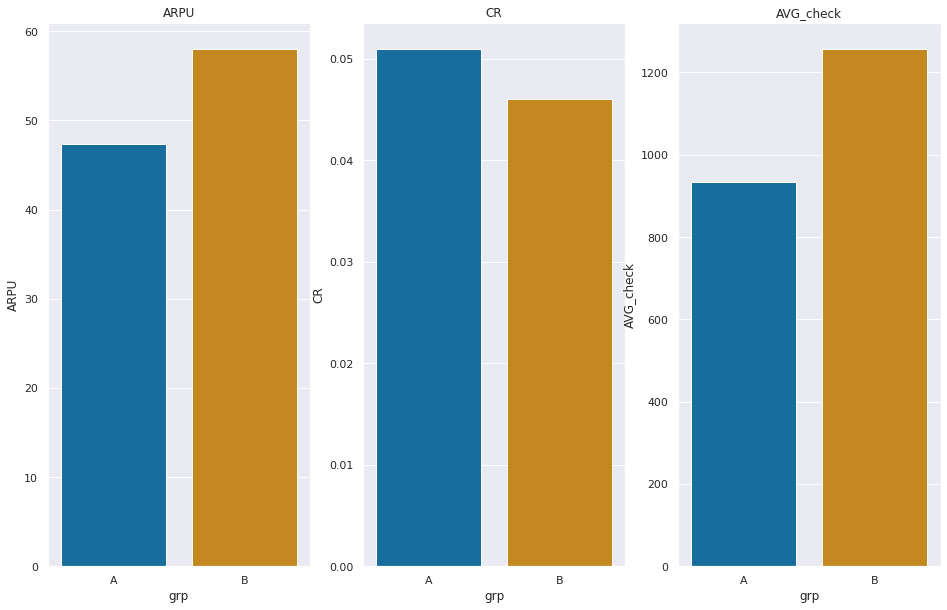

In [58]:
graphics(actual_metrics)